In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from collections import Counter
import pickle as pkl
import random
import pdb
import string
import csv
import io

# Load in data

In [3]:
def dataset_builder(path):
    
    sent1_store = []
    sent2_store = []
    label_store = []

    with open(path) as tsvfile:
        reader = csv.DictReader(tsvfile, dialect='excel-tab')
        for row in reader: 
            sent1 = [token.lower() for token in row["sentence1"].split()]
            sent2 = [token.lower() for token in row["sentence2"].split()]
            sent1_store.append(sent1)
            sent2_store.append(sent2)
            label_store.append(row["label"])     
    return sent1_store, sent2_store, label_store

In [4]:
train_sent1, train_sent2, train_label = dataset_builder("snli_train.tsv")
val_sent1, val_sent2, val_label = dataset_builder("snli_val.tsv")

In [5]:
test_set = pd.read_csv("mnli_val.tsv", sep="\t")
test_dict = {} 
# a nested dict, e.g. test_dict['fiction']['sent1'], test_dict['fiction']['sent2'], test_dict['fiction']['label']
genre_lst = pd.unique(test_set["genre"])
# array(['fiction', 'telephone', 'slate', 'government', 'travel']

for genre in genre_lst:
    test_dict[genre]={} 
    test_dict[genre]['sent1']=[]
    test_dict[genre]['sent2']=[]
    test_dict[genre]['label']=[]
    for row in test_set[test_set["genre"]==genre]['sentence1']:
        test_dict[genre]['sent1'].append([token.lower() for token in row.split()])
    for row in test_set[test_set["genre"]==genre]['sentence2']:
        test_dict[genre]['sent2'].append([token.lower() for token in row.split()])
    for row in test_set[test_set["genre"]==genre]['label']:
        test_dict[genre]['label'].append(row)

In [6]:
# double check
print ("Train dataset size is {}".format(len(train_label)))
print ("\nVal dataset size is {}".format(len(val_label)))
print ("")
for genre in genre_lst:
    print ("Test dataset size of genre {} is {}".format(genre, len(test_dict[genre]['label'])))

Train dataset size is 100000

Val dataset size is 1000

Test dataset size of genre fiction is 995
Test dataset size of genre telephone is 1005
Test dataset size of genre slate is 1002
Test dataset size of genre government is 1016
Test dataset size of genre travel is 982


In [7]:
# label list encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_label)
train_label = le.transform(train_label)
val_label = le.transform(val_label)
for genre in genre_lst:
    test_dict[genre]['label'] = le.transform(test_dict[genre]['label'])

# Build Vocabulary by pre-trained fastText

In [8]:
words_to_load = 50000

f = io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')

ft_weights = np.zeros((words_to_load, 300))
# loaded_embeddings_ft.shape = (50000, 300)
# pre-trained weights

words2idx = {} # e.g. ('the': 2)
idx2words = {} # e.g. (2: 'the')
all_words = [] # e.g. top 50k words in vocab

for i, line in enumerate(f):
    # line is str
    if i >= words_to_load: 
        break
    s = line.split() # len(s)=301, s[0] is the word, the rest is its pre-trained vector
    ft_weights[i, :] = np.asarray(s[1:])
    words2idx[s[0]] = i
    idx2words[i] = s[0]
    all_words.append(s[0])

In [9]:
PAD_IDX = 0
UNK_IDX = 1  

In [10]:
def words_indexer(data):
    indices_data = []
    for sent in data:
        index_list = [words2idx[words] if words in words2idx else UNK_IDX for words in sent]  
        indices_data.append(index_list)  
    return indices_data

In [11]:
# train
train_sent1_indices = words_indexer(train_sent1)
train_sent2_indices = words_indexer(train_sent2)

# val
val_sent1_indices = words_indexer(val_sent1)
val_sent2_indices = words_indexer(val_sent2)

# test
test_indices_dict = {}
for genre in genre_lst:
    test_indices_dict[genre] = {}
    test_indices_dict[genre]['sent1'] = words_indexer(test_dict[genre]['sent1'])
    test_indices_dict[genre]['sent2'] = words_indexer(test_dict[genre]['sent2'])

# Input Pipeline for PyTorch

In [12]:
max_sent1_length = 25
max_sent2_length = 15

class SentDataset(Dataset):
  
    def __init__(self, sent1_list, sent2_list, target_list):
    
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list
        self.target_list = target_list
        assert (len(self.sent1_list) == len(self.target_list)) and (len(self.sent2_list) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        sent1_idx = self.sent1_list[key][:max_sent1_length]
        sent2_idx = self.sent2_list[key][:max_sent2_length]
        label = self.target_list[key]
        
        return [[sent1_idx, sent2_idx], [len(sent1_idx), len(sent2_idx)], label]

In [13]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    sent1_list = []
    sent2_list = []
    label_list = []
    len1_list = []
    len2_list = []

    for datum in batch:
        label_list.append(datum[2])
        len1_list.append(datum[1][0])
        len2_list.append(datum[1][1])
    
    # padding
    for datum in batch:
        
        padded_sent1 = np.pad(np.array(datum[0][0]),
                              pad_width=((0,max_sent1_length-datum[1][0])),
                              mode="constant", constant_values=0)
        sent1_list.append(padded_sent1)
        
        padded_sent2 = np.pad(np.array(datum[0][1]),
                              pad_width=((0,max_sent2_length-datum[1][1])),
                              mode="constant", constant_values=0)
        sent2_list.append(padded_sent2)
    
#     return [torch.from_numpy(np.array(sent1_list)), torch.from_numpy(np.array(sent2_list)), 
#             torch.LongTensor(len1_list), torch.LongTensor(len2_list), 
#             torch.LongTensor(label_list)]
      
      #run on GPU
    return [torch.from_numpy(np.array(sent1_list)).cuda(), torch.from_numpy(np.array(sent2_list)).cuda(), 
            torch.LongTensor(len1_list).cuda(), torch.LongTensor(len2_list).cuda(), 
            torch.LongTensor(label_list).cuda()]

In [14]:
batch_size = 32

In [20]:
# create datasets and construct dataloader
sent_train = SentDataset(train_sent1_indices, train_sent2_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=sent_train, 
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

sent_val = SentDataset(val_sent1_indices, val_sent2_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=sent_val, 
                                         batch_size=batch_size,
                                         collate_fn=vocab_collate_func,
                                         shuffle=False)

# test
test_loader_dict = {}
for genre in genre_lst:
    test_loader_dict[genre] = torch.utils.data.DataLoader(dataset=SentDataset(test_indices_dict[genre]['sent1'], test_indices_dict[genre]['sent2'],  test_dict[genre]['label']), 
                                         batch_size=batch_size,
                                         collate_fn=vocab_collate_func,
                                         shuffle=False)

# Define Convolutional Neural Network

In [21]:
class CNN(nn.Module):
    # def __init__(self, emb_size, hidden_size, num_classes, linear_dim, kernel_size, drop_out):
    def __init__(self, emb_size, hidden_size, num_classes, linear_dim, kernel_size):
        
        super(CNN, self).__init__()

        #self.hidden_size, self.drop_out = hidden_size, drop_out
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(ft_weights), freeze=True)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
    
        self.linear1 = nn.Linear(hidden_size*2, linear_dim)
        self.linear2 = nn.Linear(linear_dim, num_classes)
        
        
           
    def forward(self, sent1, sent2, len1, len2):
        
        batch1_size, seq1_len = sent1.size()
        batch2_size, seq2_len = sent2.size()
        
        embed_sent1 = self.embedding(sent1).float()
        embed_sent2 = self.embedding(sent2).float()  
        
        hidden1 = self.conv1(embed_sent1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch1_size, hidden1.size(1), hidden1.size(-1))  
        #print(hidden1.contiguous().view(-1, hidden1.size(-1)).size()) 
        # torch.Size([32, 24, 200]) --> torch.Size([768, 200])
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch1_size, hidden1.size(1), hidden1.size(-1))
        hidden1 = torch.max(hidden1, dim=1)[0]
        
        hidden2 = self.conv1(embed_sent2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch2_size, hidden2.size(1), hidden2.size(-1))
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch2_size, hidden2.size(1), hidden2.size(-1))
        hidden2 = torch.max(hidden2, dim=1)[0]
    
        # concatenate two hidden representation 
        hidden_cat = torch.cat([hidden1, hidden2], dim=1)
        
        # feed to 2-layer fully connected
        out = self.linear1(hidden_cat)
        # out= F.dropout(out, self.drop_out)
        out = F.relu(out)
        logits = self.linear2(out)
        
        return logits

# Training

In [22]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sent1, sent2, len1, len2, labels in loader:
        sent1_batch, sent2_batch, len1_batch, len2_batch, label_batch = sent1, sent2, len1, len2, labels
        outputs = F.softmax(model(sent1_batch, sent2_batch, len1_batch, len2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [23]:
#model = CNN(emb_size=300, hidden_size=200, num_classes=3, linear_dim=100, kernel_size=1, drop_out=0.7)
model = CNN(emb_size=300, hidden_size=1000, num_classes=3, linear_dim=100, kernel_size=2)
model.cuda()

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Train the model
loss_store = []
train_acc_store = []
val_acc_store = []

for epoch in range(num_epochs):
    
    epoch_loss_lst =[]
    
    for i, (sent1, sent2, len1, len2, labels) in enumerate(train_loader):
        
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(sent1, sent2, len1, len2)
        loss = criterion(outputs, labels)
        epoch_loss_lst.append(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # validate every 100 iterations
        if i > 0 and i % 200 == 0:
            
            # train
            train_acc = test_model(train_loader, model)
            train_acc_store.append(train_acc)
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_store.append(val_acc)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Training Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
    
    loss_store.append(sum(epoch_loss_lst).cpu().detach().numpy())


Epoch: [1/10], Step: [201/3125], Training Acc: 33.291, Validation Acc: 33.6
Epoch: [1/10], Step: [401/3125], Training Acc: 46.862, Validation Acc: 47.3
Epoch: [1/10], Step: [601/3125], Training Acc: 35.969, Validation Acc: 35.8
Epoch: [1/10], Step: [801/3125], Training Acc: 55.721, Validation Acc: 55.4
Epoch: [1/10], Step: [1001/3125], Training Acc: 57.317, Validation Acc: 56.3
Epoch: [1/10], Step: [1201/3125], Training Acc: 58.262, Validation Acc: 57.4
Epoch: [1/10], Step: [1401/3125], Training Acc: 59.048, Validation Acc: 57.6
Epoch: [1/10], Step: [1601/3125], Training Acc: 56.504, Validation Acc: 55.2
Epoch: [1/10], Step: [1801/3125], Training Acc: 59.875, Validation Acc: 58.0
Epoch: [1/10], Step: [2001/3125], Training Acc: 60.392, Validation Acc: 58.9
Epoch: [1/10], Step: [2201/3125], Training Acc: 59.303, Validation Acc: 58.1
Epoch: [1/10], Step: [2401/3125], Training Acc: 60.395, Validation Acc: 59.6
Epoch: [1/10], Step: [2601/3125], Training Acc: 61.442, Validation Acc: 59.9
Epo

Epoch: [8/10], Step: [601/3125], Training Acc: 81.536, Validation Acc: 69.8
Epoch: [8/10], Step: [801/3125], Training Acc: 80.73, Validation Acc: 68.6
Epoch: [8/10], Step: [1001/3125], Training Acc: 81.479, Validation Acc: 68.3
Epoch: [8/10], Step: [1201/3125], Training Acc: 81.408, Validation Acc: 68.7
Epoch: [8/10], Step: [1401/3125], Training Acc: 81.947, Validation Acc: 67.9
Epoch: [8/10], Step: [1601/3125], Training Acc: 82.434, Validation Acc: 69.1
Epoch: [8/10], Step: [1801/3125], Training Acc: 82.261, Validation Acc: 68.3
Epoch: [8/10], Step: [2001/3125], Training Acc: 81.981, Validation Acc: 69.1
Epoch: [8/10], Step: [2201/3125], Training Acc: 82.946, Validation Acc: 69.7
Epoch: [8/10], Step: [2401/3125], Training Acc: 83.186, Validation Acc: 68.9
Epoch: [8/10], Step: [2601/3125], Training Acc: 83.386, Validation Acc: 69.3
Epoch: [8/10], Step: [2801/3125], Training Acc: 83.647, Validation Acc: 69.0
Epoch: [8/10], Step: [3001/3125], Training Acc: 82.293, Validation Acc: 69.0
Ep

In [ ]:
# save the result for later plotting
acc_dict = {}
loss_dict = {}
loss_dict['training loss'] = loss_store
acc_dict['training accuracy'] = train_acc_store
acc_dict['validation accuracy'] = val_acc_store
acc_df = pd.DataFrame(acc_dict)
loss_df = pd.DataFrame(loss_dict)
acc_df.to_csv("acc_h1000_k1_d0.csv")
loss_df.to_csv("loss_h1000_k1_d0.csv")

# Hyparameter Tuning
### read in csv file and plot

# 1. Kernel Size

In [46]:
val_acc_k2 = pd.read_csv("./ConvNet/acc_h200_k2_d0.csv")['validation accuracy']
val_acc_k3 = pd.read_csv("./ConvNet/acc_h200_k3_d0.csv")['validation accuracy']
val_acc_k4 = pd.read_csv("./ConvNet/acc_h200_k4_d0.csv")['validation accuracy']
val_acc_k5 = pd.read_csv("./ConvNet/acc_h200_k5_d0.csv")['validation accuracy']

In [47]:
max(val_acc_k2)

71.0

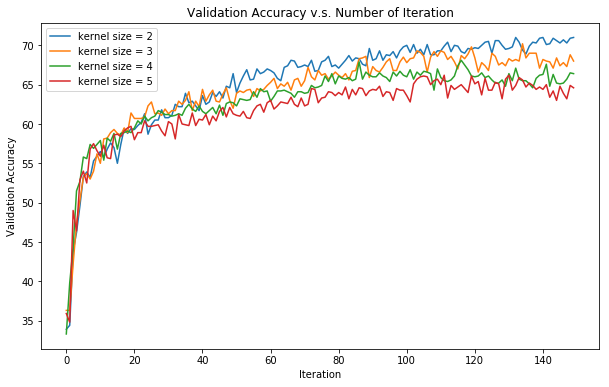

In [48]:
# plot
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_k2, label="kernel size = 2")
plt.plot(val_acc_k3, label="kernel size = 3")
plt.plot(val_acc_k4, label="kernel size = 4")
plt.plot(val_acc_k5, label="kernel size = 5")
plt.legend(loc="best")
plt.savefig("kernel.png")
plt.show()

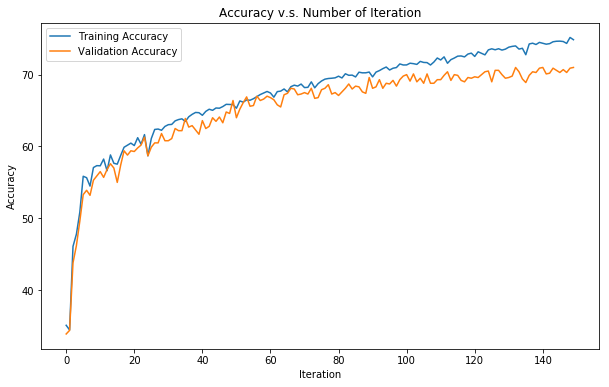

In [49]:
# plot
train_acc_k2 = pd.read_csv("./ConvNet/acc_h200_k2_d0.csv")['training accuracy']
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy v.s. Number of Iteration")
plt.plot(train_acc_k2, label="Training Accuracy")
plt.plot(val_acc_k2, label="Validation Accuracy")
plt.legend(loc="best")
plt.savefig("kernel_tvacc.png")
plt.show()

In [73]:
loss_k2 = pd.read_csv("./ConvNet/loss_h200_k2_d0.csv")['training loss']
loss_k3 = pd.read_csv("./ConvNet/loss_h200_k3_d0.csv")['training loss']
loss_k4 = pd.read_csv("./ConvNet/loss_h200_k4_d0.csv")['training loss']
loss_k5 = pd.read_csv("./ConvNet/loss_h200_k5_d0.csv")['training loss']

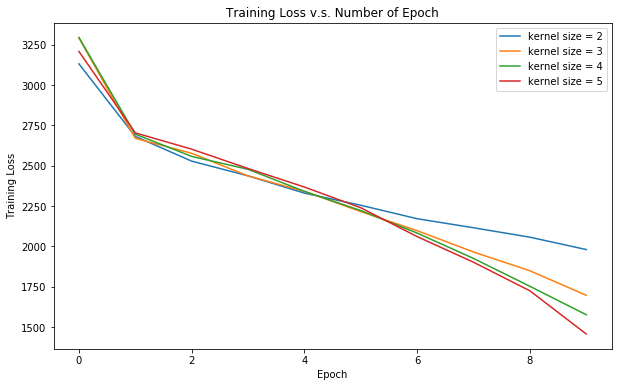

In [74]:
# plot
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(loss_k2, label="kernel size = 2")
plt.plot(loss_k3, label="kernel size = 3")
plt.plot(loss_k4, label="kernel size = 4")
plt.plot(loss_k5, label="kernel size = 5")
plt.legend(loc="best")
plt.savefig("kernel_loss.png")
plt.show()

# 2. Drop Out

In [57]:
val_acc_d0 = pd.read_csv("./ConvNet/acc_h200_k2_d0.csv")['validation accuracy']
val_acc_d3 = pd.read_csv("./ConvNet/acc_h200_k2_d3.csv")['validation accuracy']
val_acc_d5 = pd.read_csv("./ConvNet/acc_h200_k2_d5.csv")['validation accuracy']
val_acc_d7 = pd.read_csv("./ConvNet/acc_h200_k2_d7.csv")['validation accuracy']

In [58]:
max(val_acc_d7)

69.6

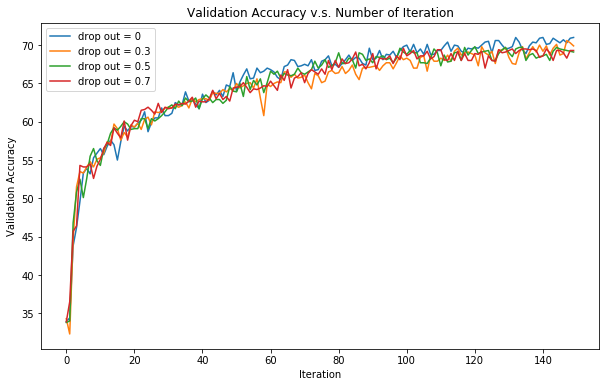

In [59]:
# plot
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_d0, label="drop out = 0")
plt.plot(val_acc_d3, label="drop out = 0.3")
plt.plot(val_acc_d5, label="drop out = 0.5")
plt.plot(val_acc_d7, label="drop out = 0.7")
plt.legend(loc="best")
plt.savefig("ConvNet_dropout.png")
plt.show()

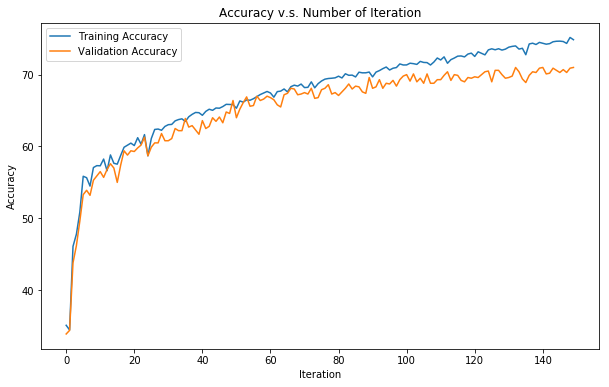

In [60]:
# plot
train_acc_d0 = pd.read_csv("./ConvNet/acc_h200_k2_d0.csv")['training accuracy']
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy v.s. Number of Iteration")
plt.plot(train_acc_d0, label="Training Accuracy")
plt.plot(val_acc_d0, label="Validation Accuracy")
plt.legend(loc="best")
plt.savefig("dropout_tvacc.png")
plt.show()

In [61]:
loss_d0 = pd.read_csv("./ConvNet/loss_h200_k1_d0.csv")['training loss']
loss_d3 = pd.read_csv("./ConvNet/loss_h200_k1_d3.csv")['training loss']
loss_d5 = pd.read_csv("./ConvNet/loss_h200_k1_d5.csv")['training loss']
loss_d7 = pd.read_csv("./ConvNet/loss_h200_k1_d7.csv")['training loss']

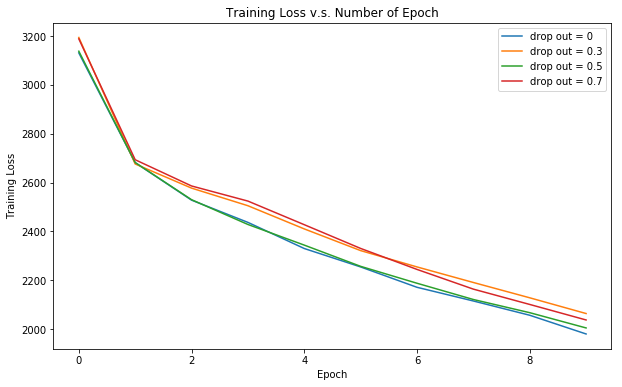

In [62]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(loss_d0, label="drop out = 0")
plt.plot(loss_d3, label="drop out = 0.3")
plt.plot(loss_d5, label="drop out = 0.5")
plt.plot(loss_d7, label="drop out = 0.7")
plt.legend(loc="best")
#plt.savefig("GRN_hidden_loss.png")
plt.show()

# 3. Hidden Size (Output Channel)

In [64]:
val_acc_h50 = pd.read_csv("./ConvNet/acc_h50_k2_d0.csv")['validation accuracy']
val_acc_h100 = pd.read_csv("./ConvNet/acc_h100_k2_d0.csv")['validation accuracy']
val_acc_h200 = pd.read_csv("./ConvNet/acc_h200_k2_d0.csv")['validation accuracy']
val_acc_h400 = pd.read_csv("./ConvNet/acc_h400_k2_d0.csv")['validation accuracy']
val_acc_h600 = pd.read_csv("./ConvNet/acc_h600_k2_d0.csv")['validation accuracy']
val_acc_h800 = pd.read_csv("./ConvNet/acc_h800_k2_d0.csv")['validation accuracy']
val_acc_h1000 = pd.read_csv("./ConvNet/acc_h1000_k2_d0.csv")['validation accuracy']

In [67]:
max(val_acc_h1000)

72.5

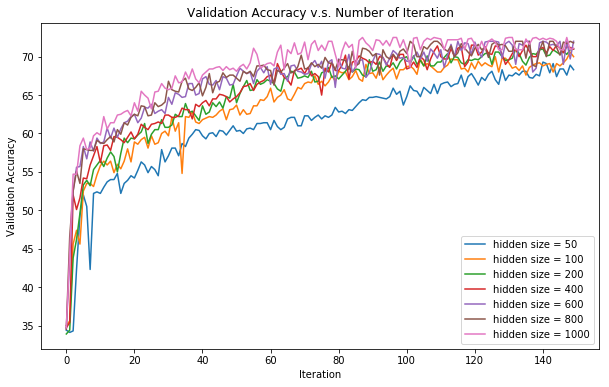

In [66]:
# plot
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Accuracy')
ax.set_title("Validation Accuracy v.s. Number of Iteration")
plt.plot(val_acc_h50, label="hidden size = 50")
plt.plot(val_acc_h100, label="hidden size = 100")
plt.plot(val_acc_h200, label="hidden size = 200")
plt.plot(val_acc_h400, label="hidden size = 400")
plt.plot(val_acc_h600, label="hidden size = 600")
plt.plot(val_acc_h800, label="hidden size = 800")
plt.plot(val_acc_h1000, label="hidden size = 1000")
plt.legend(loc="best")
plt.savefig("ConvNet_hidden.png")
plt.show()

In [70]:
loss_h50 = pd.read_csv("./ConvNet/loss_h50_k2_d0.csv")['training loss']
loss_h100 = pd.read_csv("./ConvNet/loss_h100_k2_d0.csv")['training loss']
loss_h200 = pd.read_csv("./ConvNet/loss_h200_k2_d0.csv")['training loss']
loss_h400 = pd.read_csv("./ConvNet/loss_h400_k2_d0.csv")['training loss']
loss_h600 = pd.read_csv("./ConvNet/loss_h600_k2_d0.csv")['training loss']
loss_h800 = pd.read_csv("./ConvNet/loss_h800_k2_d0.csv")['training loss']
loss_h1000 = pd.read_csv("./ConvNet/loss_h1000_k2_d0.csv")['training loss']

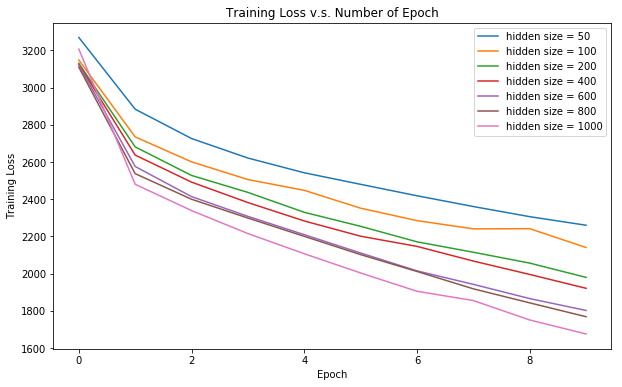

In [71]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title("Training Loss v.s. Number of Epoch")
plt.plot(loss_h50, label="hidden size = 50")
plt.plot(loss_h100, label="hidden size = 100")
plt.plot(loss_h200, label="hidden size = 200")
plt.plot(loss_h400, label="hidden size = 400")
plt.plot(loss_h600, label="hidden size = 600")
plt.plot(loss_h800, label="hidden size = 800")
plt.plot(loss_h1000, label="hidden size = 1000")
plt.legend(loc="best")
#plt.savefig("GRN_hidden_loss.png")
plt.show()

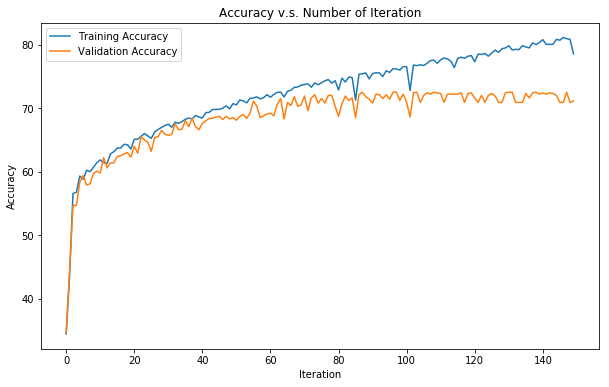

In [68]:
train_acc_h1000 = pd.read_csv("./ConvNet/acc_h1000_k2_d0.csv")['training accuracy']
fig, ax = plt.subplots(figsize=(10,6)) 
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy v.s. Number of Iteration")
plt.plot(train_acc_h1000, label="Training Accuracy")
plt.plot(val_acc_h1000, label="Validation Accuracy")
plt.legend(loc="best")
plt.savefig("hidden_tvacc.png")
plt.show()

# Evaluateing Best Model in MultiNLI Set
### Configuration: kernel_size = 2, hidden_size = 1000, drop_out = 0

In [25]:
test_dict = {}
test_dict["genre"] = genre_lst
test_dict["test acc"] = []
for genre in genre_lst:
    test_dict["test acc"].append(test_model(test_loader_dict[genre], model))
test_df = pd.DataFrame(test_dict)
test_df

,genre,test acc
0,fiction,47.035176
1,telephone,47.960199
2,slate,42.814371
3,government,45.767717
4,travel,43.991853


### End of hw2 ConvNet